In [10]:
import pandas as pd
import random
import glob
import pathlib
import os
import cv2
import numpy as np
import sys
import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import keras
import gc
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [35]:
data = pd.read_csv("labels.csv")

label_to_index = {'Cargo': 0,
                  'Military': 1,
                  'Carrier': 2,
                  'Cruise': 3,
                  'Tanker': 4}
index_to_label = {v: k for k, v in label_to_index.items()}

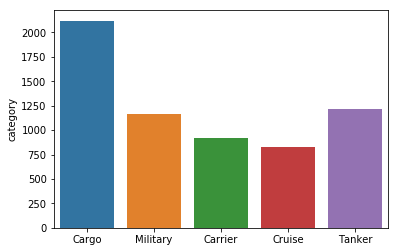

In [37]:
sns.barplot([k for k, v in label_to_index.items()], data["category"].value_counts().sort_index())

In [13]:
IMG_SIZE = 224

def preprocess_image(path):
    img = cv2.imread(path, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return (cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0)

In [16]:
x_train = np.zeros(shape=(len(data.image), IMG_SIZE, IMG_SIZE, 3))
for i, image in tqdm.tqdm(enumerate(data.image)):
    x_train[i] = preprocess_image("images\\" + image)

6252it [00:56, 110.25it/s]


In [33]:
y_train = data.category
y_train = np.eye(np.max(y_train))[y_train - 1].astype(int)

In [38]:
print(x_train.shape)
print(y_train.shape)

(6252, 224, 224, 3)
(6252, 5)


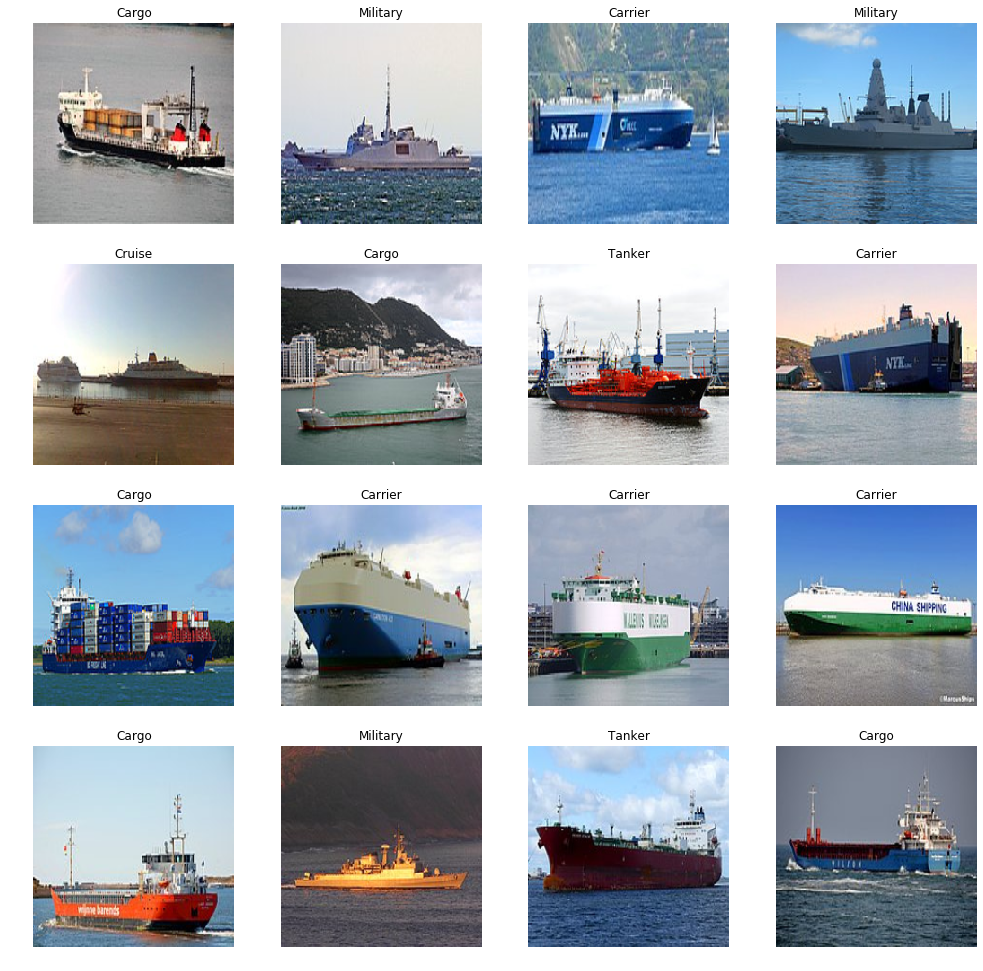

In [36]:
fig = plt.figure(figsize=(17, 17))
for i in range(1, 17):
    ax1 = fig.add_subplot(4, 4,i)
    ax1.imshow(x_train[i])
    ax1.title.set_text(index_to_label[np.where(y_train[i]==1)[0][0]])
    plt.axis("off")

In [40]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

datagen = ImageDataGenerator(rotation_range=45,
                             height_shift_range=0.3,
                             width_shift_range=0.3,
                             horizontal_flip=True) \
                             .fit(x_train, augment=True, rounds=1, seed=2019)

train_generator = datagen.flow(x_train, y_train, batch_size=8, seed=2019)

epoch_steps = train_generator.n // train_generator.batch_size

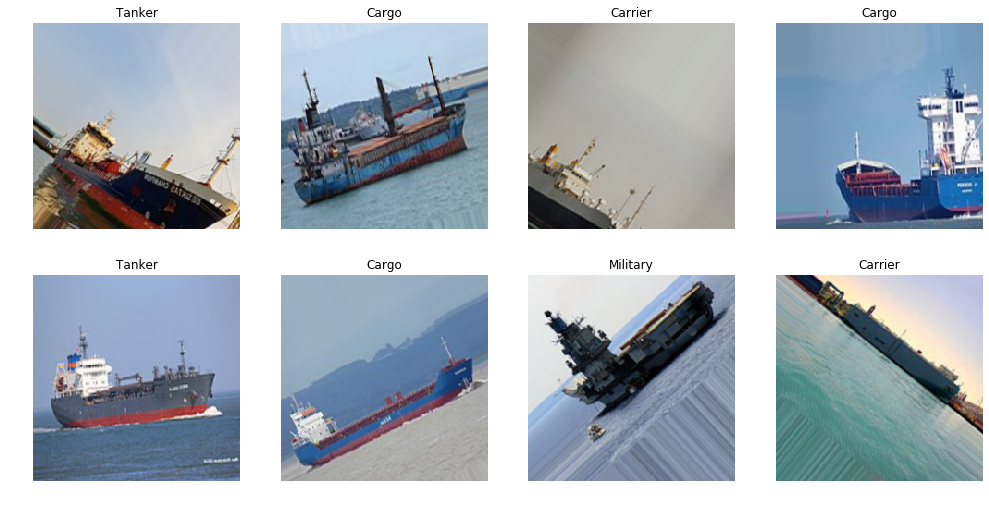

In [51]:
fig = plt.figure(figsize=(17, 8.5))

for i in range(1, 9):
    ax1 = fig.add_subplot(2, 4, i)
    ax1.axis('off')
    ax1.title.set_text(index_to_label[np.where(batch[1][i - 1]==1)[0][0]])
    ax1.imshow(batch[0][i - 1])

In [52]:
model = keras.models.Sequential([
    keras.applications.Xception(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

gc.collect()

W0812 08:36:53.238080  7256 deprecation_wrapper.py:119] From c:\users\aya708\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 08:36:53.408753  7256 deprecation_wrapper.py:119] From c:\users\aya708\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 08:36:53.461448  7256 deprecation_wrapper.py:119] From c:\users\aya708\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0812 08:36:53.529495  7256 deprecation_wrapper.py:119] From c:\users\aya708\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is de

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 20,871,725
Trainable params: 20,817,197
Non-trainable params: 54,528
_________________________________________________________________


0

In [53]:
mcp_save = keras.callbacks.ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5',
                                           verbose=1,
                                           monitor='val_loss',
                                           mode='auto')

reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')

history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=30,
                   callbacks=[mcp_save, reduce_lr_loss],
                   validation_data=[x_valid, y_valid])